## Train AE

run_count  epoch  data_fidelity  val_fidelity  batch_size     lr device  \
0           1      0       0.230870    432.881880          32  0.001   cuda   
1           1      1       0.163587    306.726049          32  0.001   cuda   
2           1      2       0.149023    279.419043          32  0.001   cuda   
3           1      3       0.140191    262.857299          32  0.001   cuda   
4           1      4       0.133597    250.495013          32  0.001   cuda   
..        ...    ...            ...           ...         ...    ...    ...   
95          1     95       0.079633    149.311730          32  0.001   cuda   
96          1     96       0.079557    149.169615          32  0.001   cuda   
97          1     97       0.079392    148.860717          32  0.001   cuda   
98          1     98       0.079284    148.658157          32  0.001   cuda   
99          1     99       0.079155    148.415730          32  0.001   cuda   

    z_dim  
0       9  
1       9  
2       9  
3       9  
4       9  
..    ...  
95      9  
96      9  
97      9  
98      9  
99      9  

[100 rows x 8 columns]

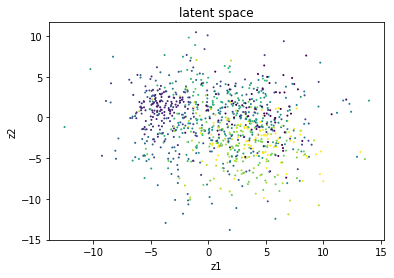

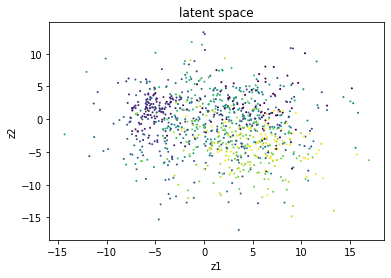

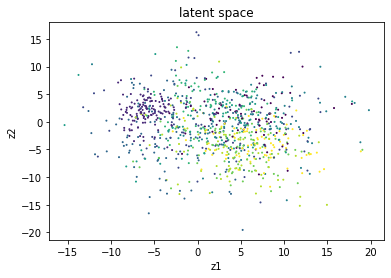

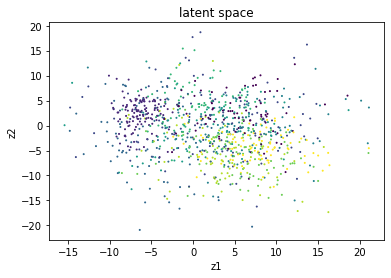

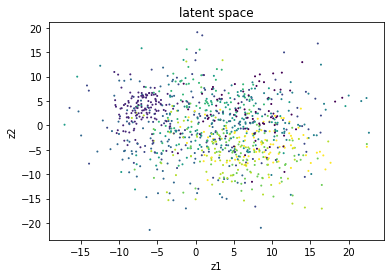

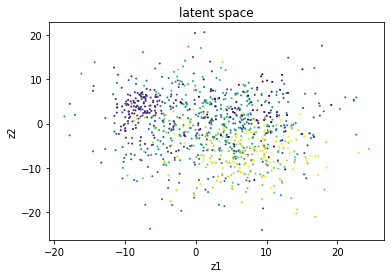

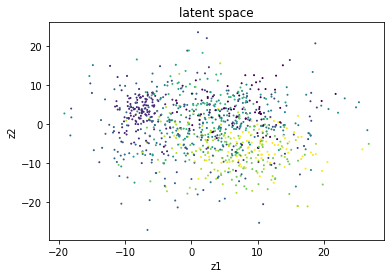

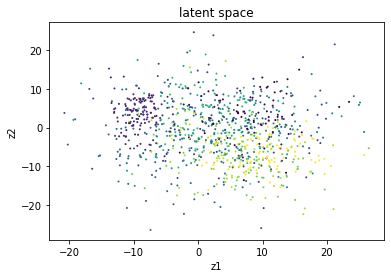

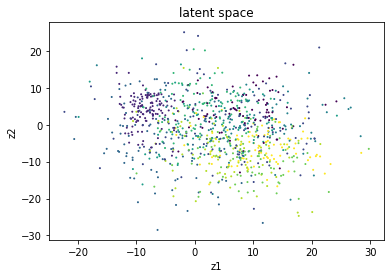

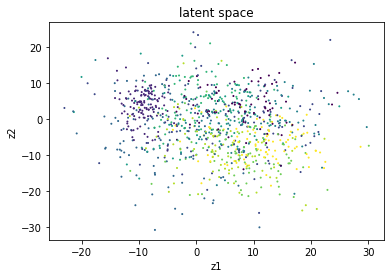

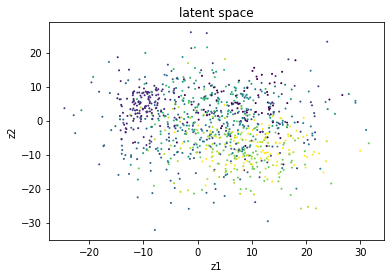

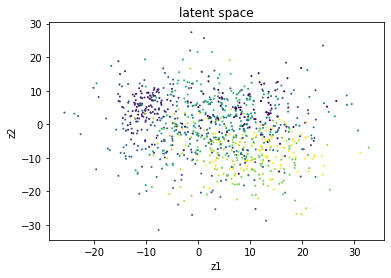

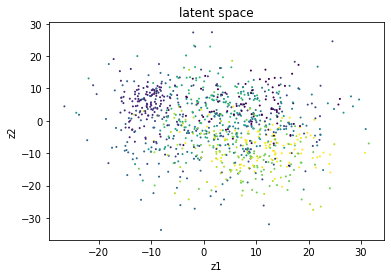

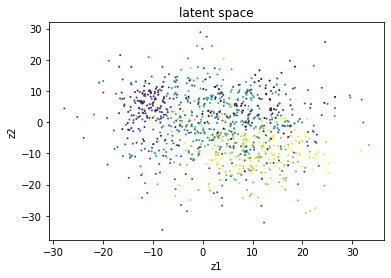

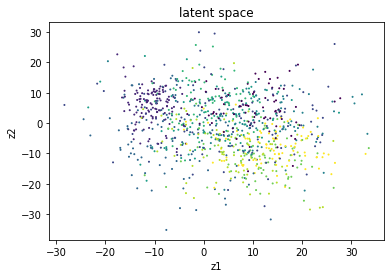

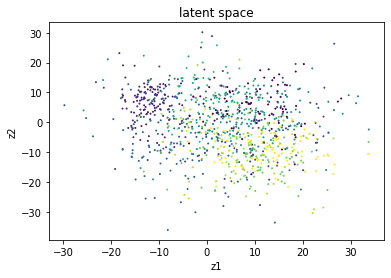

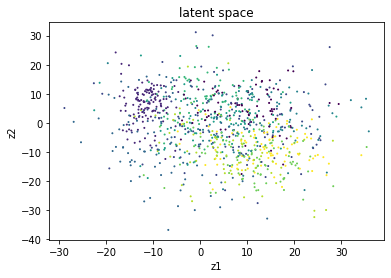

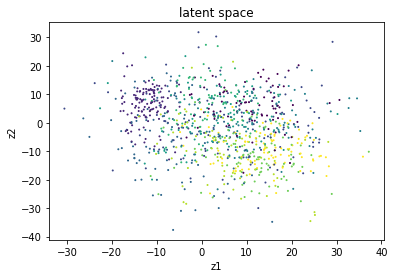

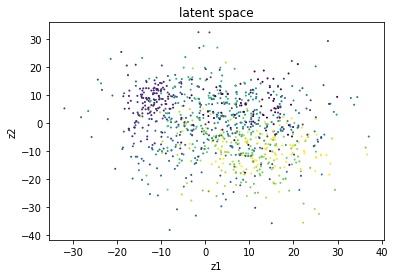

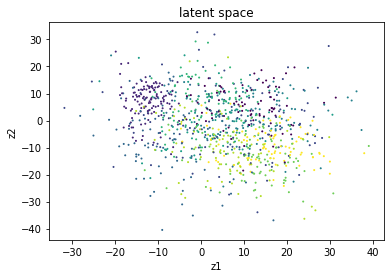

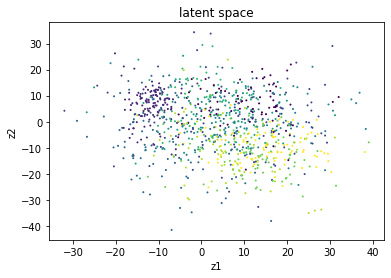

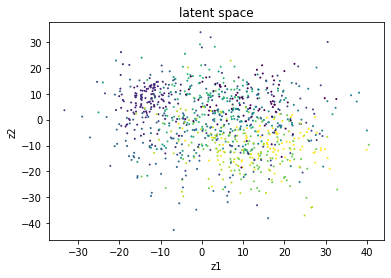

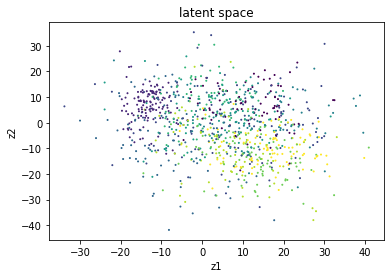

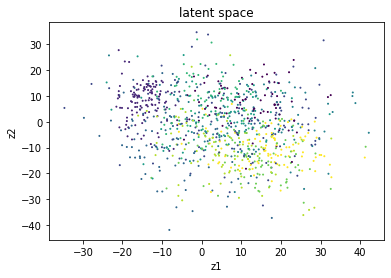

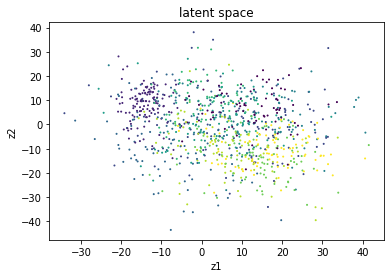

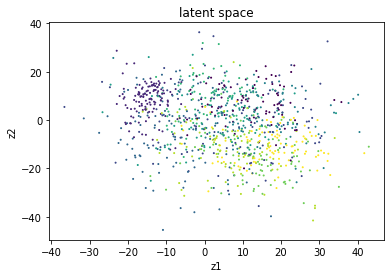

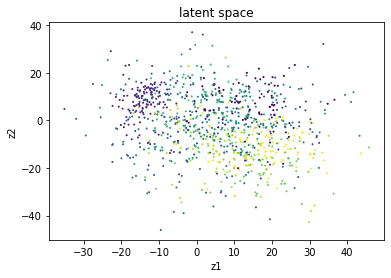

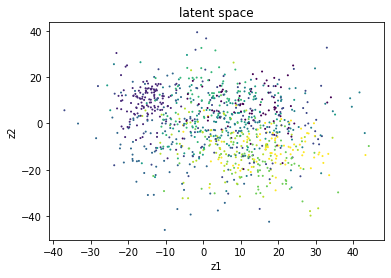

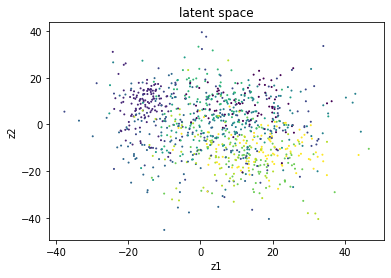

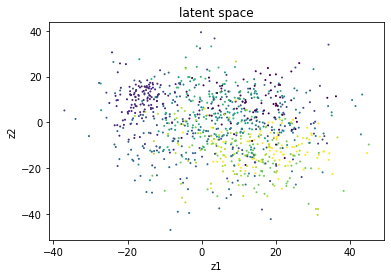

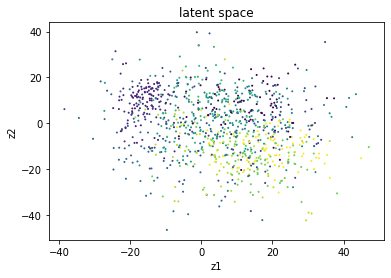

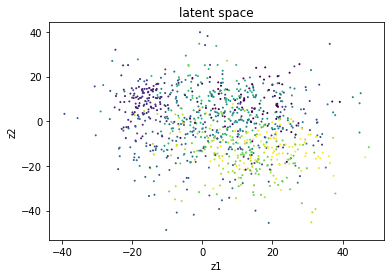

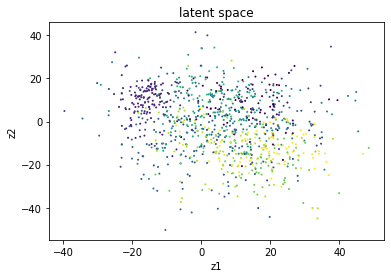

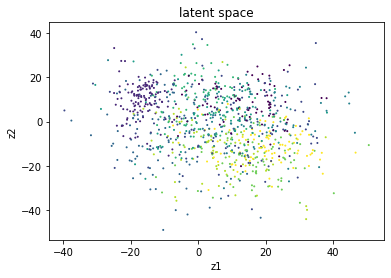

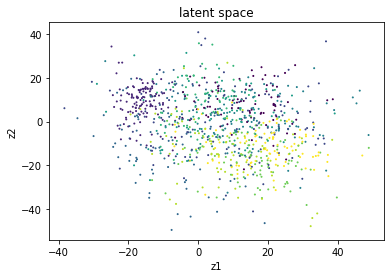

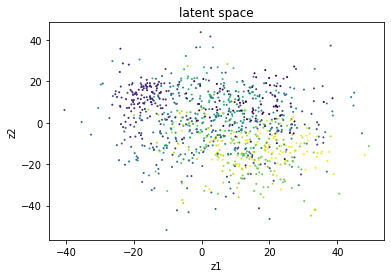

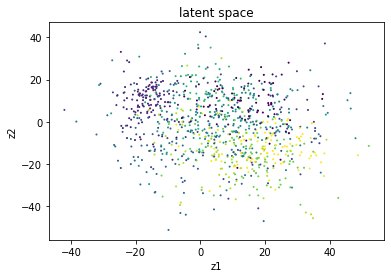

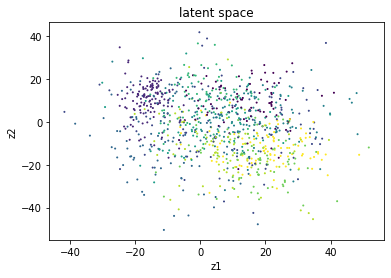

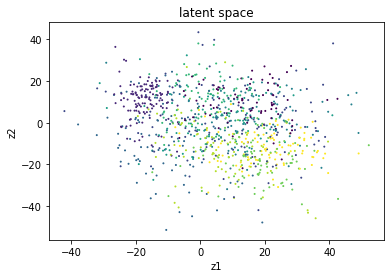

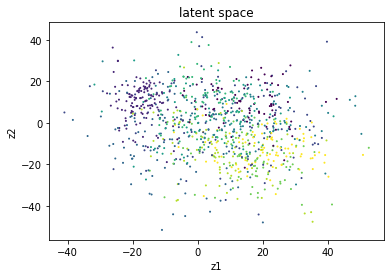

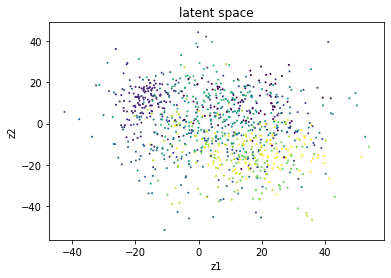

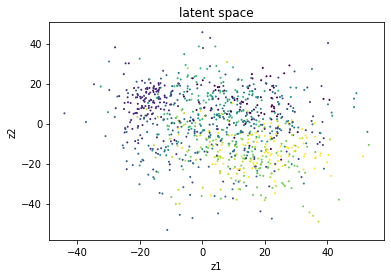

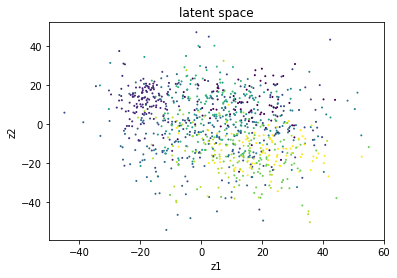

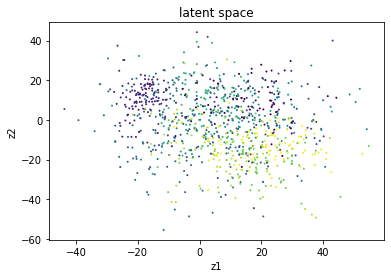

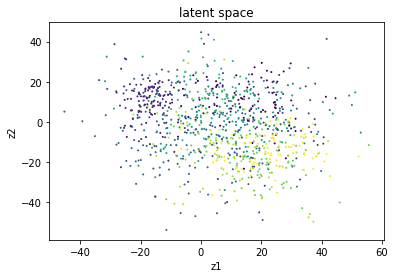

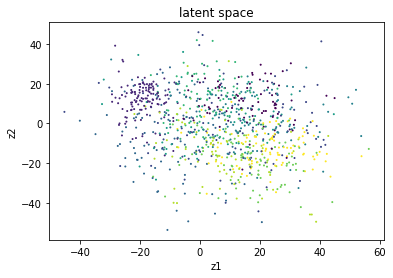

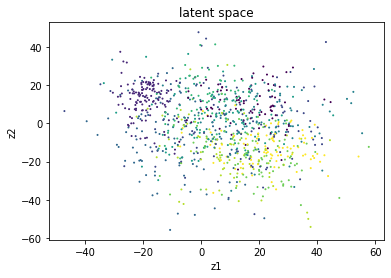

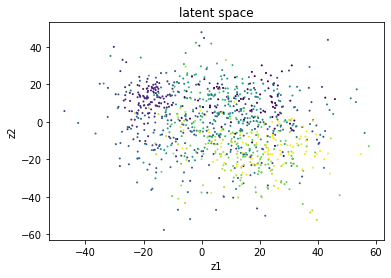

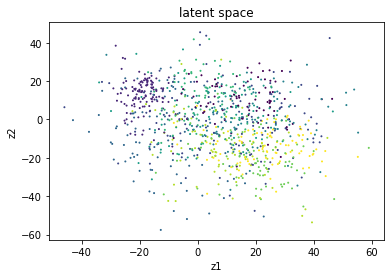

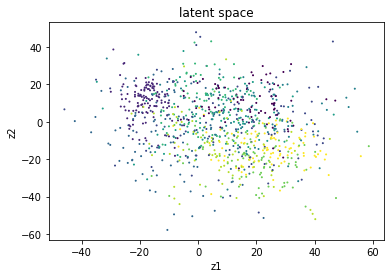

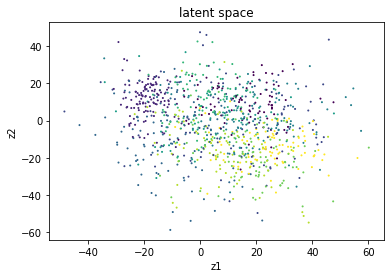

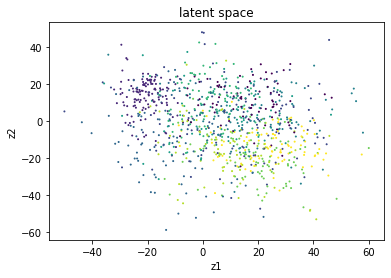

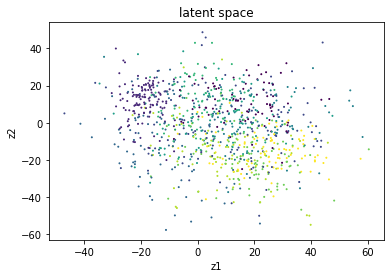

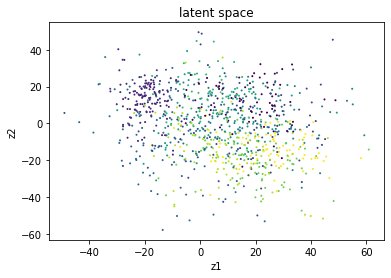

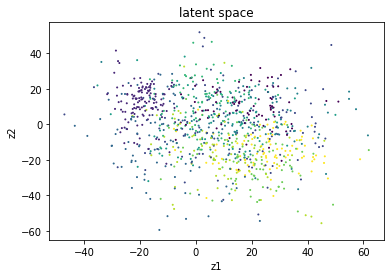

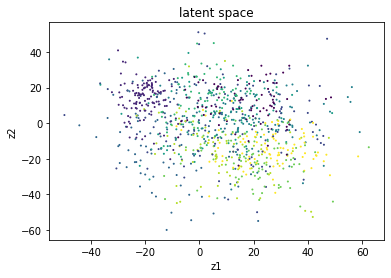

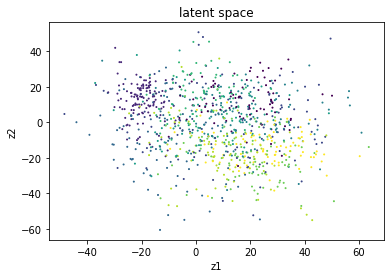

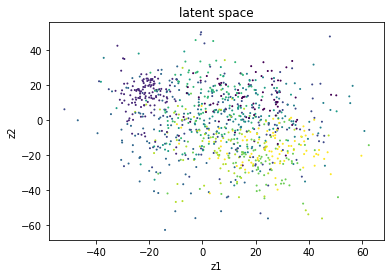

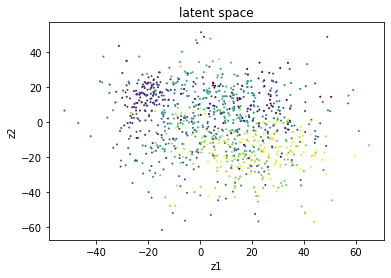

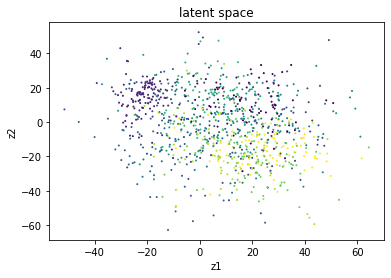

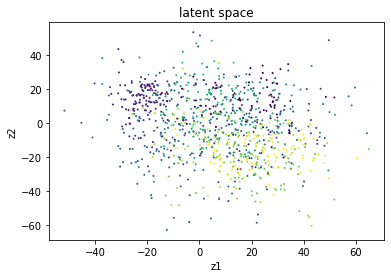

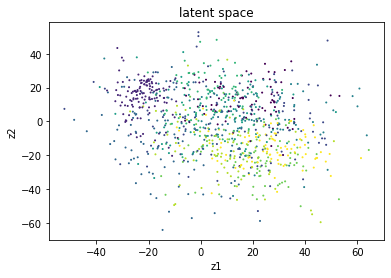

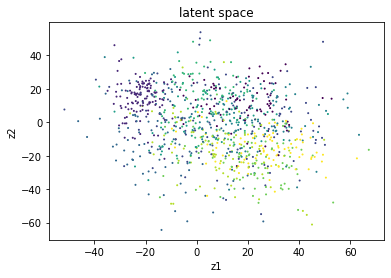

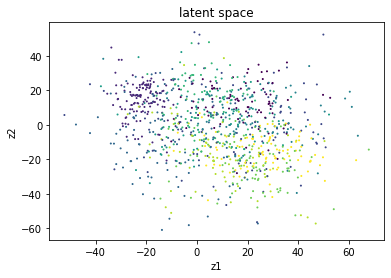

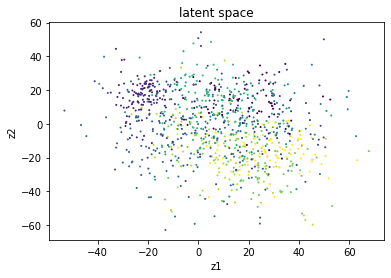

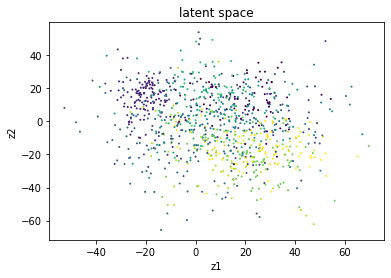

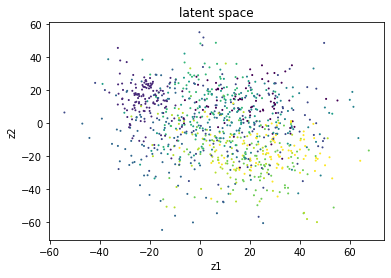

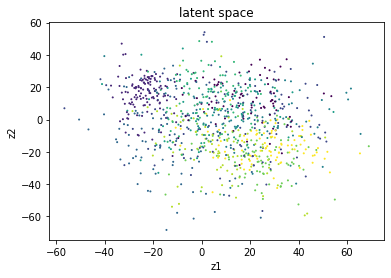

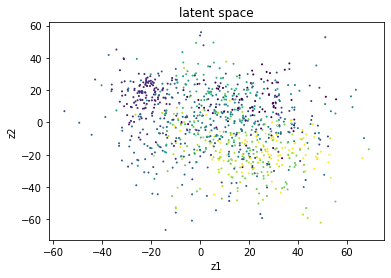

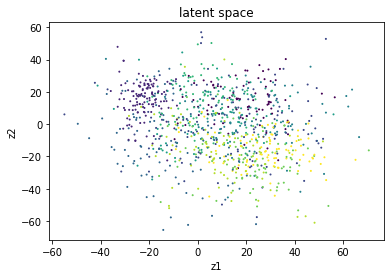

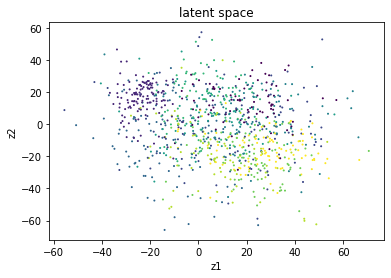

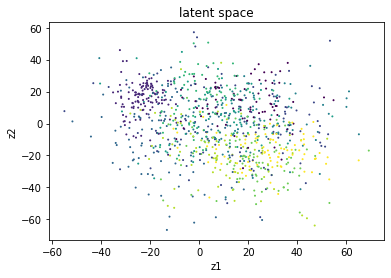

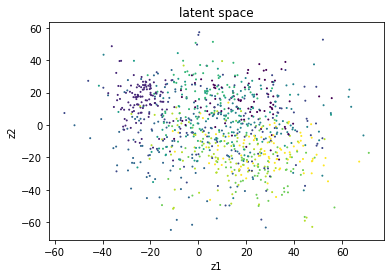

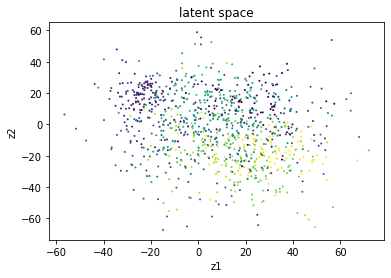

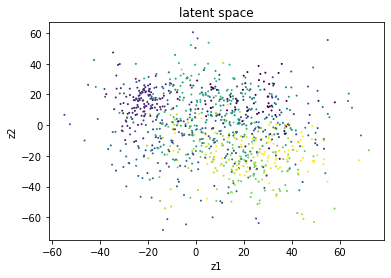

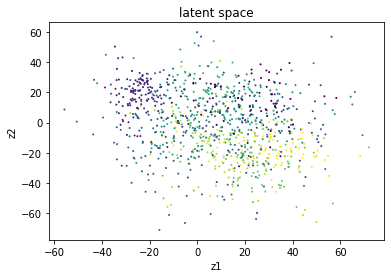

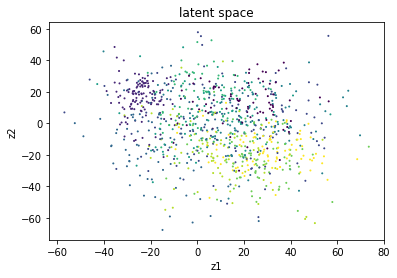

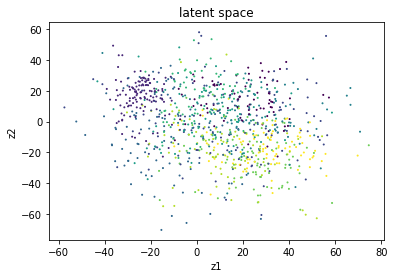

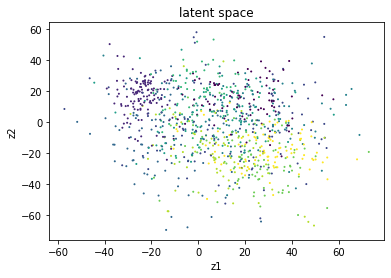

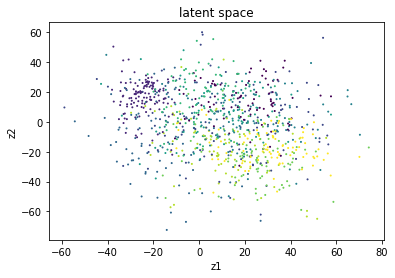

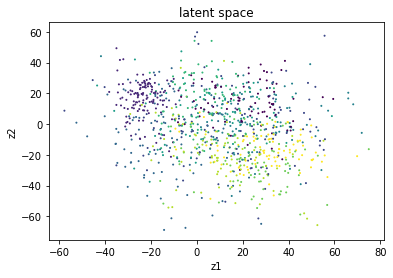

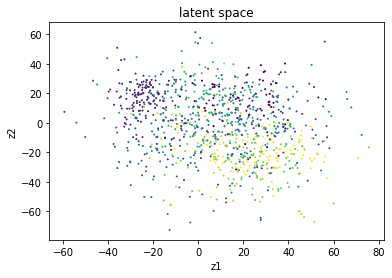

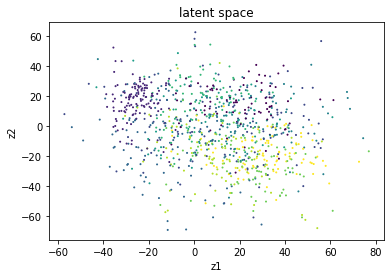

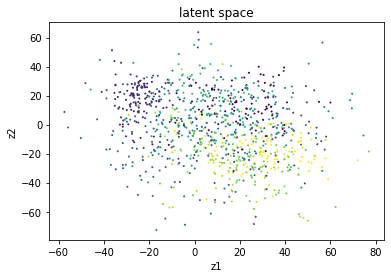

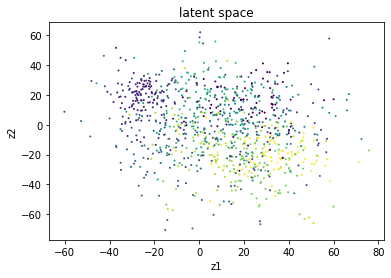

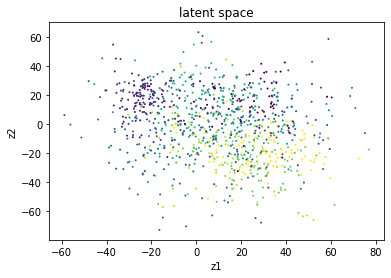

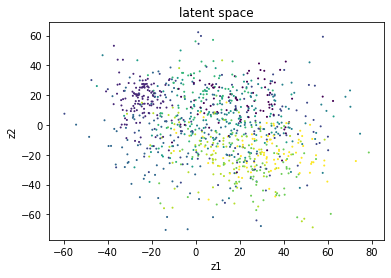

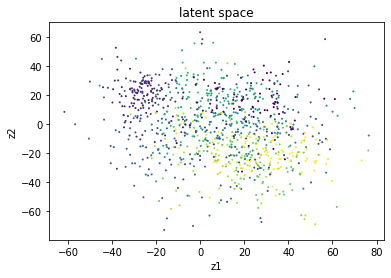

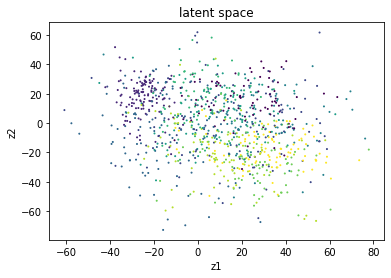

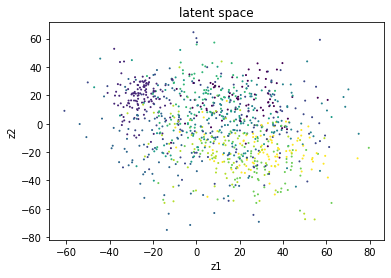

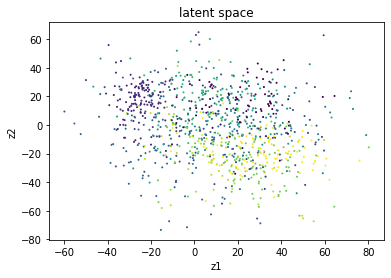

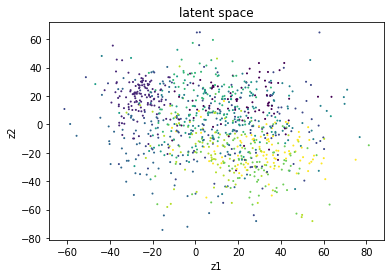

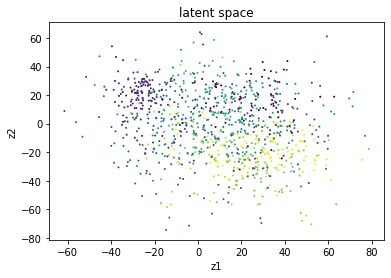

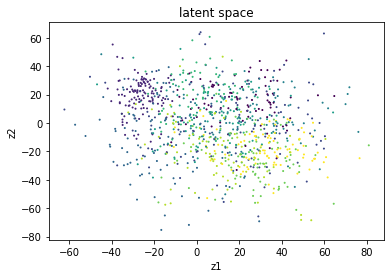

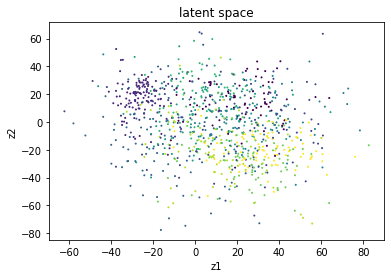

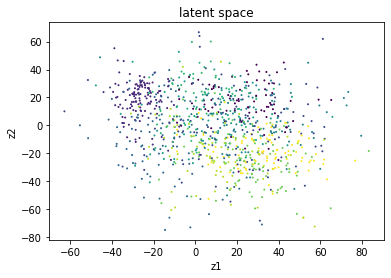

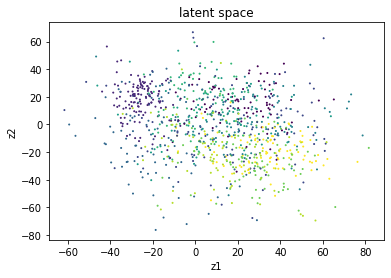

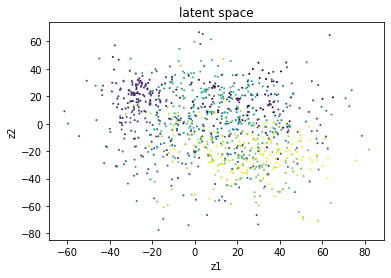

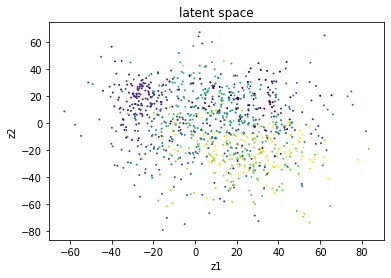

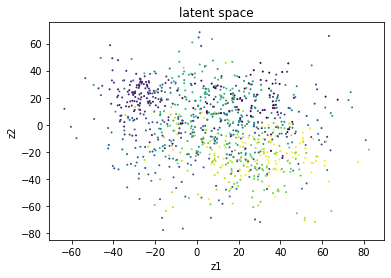

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
from models.ae import MNISTAutoencoder
from models.generator import MNISTGenerator
import matplotlib.pyplot as plt
from dataset import MNISTDataset, MNIST_mean, MNIST_std
from utils.plot_utils import show_latent

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [32],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    beta = [10],
    z_dim = [9], 
    manual_seed = [1265],
    loss_func = [nn.MSELoss]
)

train_set = MNISTDataset(path='data/MNIST/processed', normalize=True)
val_set = MNISTDataset(path='data/MNIST/processed', train=False, normalize=True)

run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0
for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    model = MNISTAutoencoder(latent_dim=run.z_dim)
    model = model.to(device)
    loader = torch.utils.data.DataLoader(train_set, 
                                         batch_size=run.batch_size, 
                                         shuffle=run.shuffle, 
                                         num_workers=run.num_workers
                                        )
    
    val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size=run.batch_size, 
                                         shuffle=run.shuffle, 
                                         num_workers=run.num_workers
                                        )

    optimizer = torch.optim.Adam(model.parameters(), lr=run.lr)
    num_batches = len(train_set)/run.batch_size
    criterion = run.loss_func()
    num_val_batches = len(val_set)/run.batch_size
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        results['z_dim'] = run.z_dim
        
#         run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        model = model.to(device)
     
        for batch in tqdm(loader):
            batch_count +=1
            optimizer.zero_grad()

            X = batch
            X = X.to(device=run.device)
            out = model(X)
            
            loss = criterion(out, X)
            loss.backward()
            optimizer.step()
            
#             print(' backward time', time.time() - forward_time)
            total_recons_loss += loss.item()
            
        
        X = val_set.dataset[0:1000].unsqueeze(dim=1)
        temp = model.to('cpu')
        latent = temp.encoder(X)
        out = temp.decoder(latent)

        loss = criterion(out, X)            
        total_val_loss += loss.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        results['z_dim'] = run.z_dim
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        show_latent(latent.detach(), val_set.labels[0:1000])
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(model, 'trained_models/mnist_ae_jun7_z_9.model'.format(run.lr,run.beta, run.z_dim))
    models.append(model)

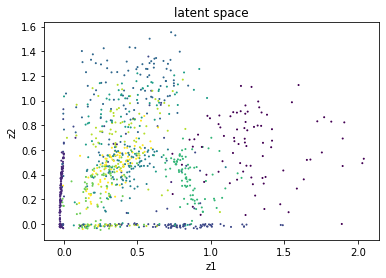

In [6]:
show_latent(latent.detach(), val_set.labels[0:1000])

In [2]:
X = val_set.dataset[0:10000].unsqueeze(dim=1)
temp = model.to('cpu')
latent = temp.encoder(X)

In [15]:
inp = train_set[1].unsqueeze(dim=1)
model = model.to('cpu')
model.eval()

out = model(inp)

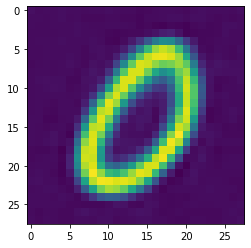

In [21]:
plt.imshow(out.detach().squeeze().numpy())

In [ ]:
a = model()

In [4]:
X[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [1]:
from dataset import MNISTDataset

import torch
import os

train_set = MNISTDataset('data/MNIST/processed', normalize=True)

/scratch/sagar/Projects/flow/glow-pytorch/dataset.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset = torch.tensor(self.dataset, dtype=torch.float32)


In [2]:
import matplotlib.pyplot as plt

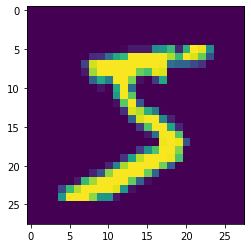

In [3]:
plt.imshow(train_set[0].squeeze())

In [4]:
train_set[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [15]:
ld = torch.utils.data.DataLoader(train_set, transform=)

In [1]:
from dataset import MNISTDataset

import torch
import os
data = torch.load(os.path.join('data/MNIST/processed', 'training.pt'))


In [16]:
a, _ = data
a = torch.tensor(a, dtype=torch.float32)

/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [6]:
a,_ = data

In [12]:
(a/255.0).std()

tensor(0.3081)